In [467]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import numpy as np
import pandas as pd
import datetime
import os
import csv
import random
import io
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [468]:
num_lags = 3
#1,5,10,20,30
timesteps = 6
setting = 'LSTM_monthly_R3_'+str(timesteps)
title = 'LSTM (ReLU, 3 Hidden Layers) Model Performance for Monthly Data: '+str(timesteps)+' Time Step'
if timesteps != 1:
    title += 's'

In [469]:
# read in data
data_type = 'average' #'min', 'max'
df = pd.read_csv('j17_monthly.csv')
pd.DataFrame.reset_index(df, drop=True)
# standardize data
def z_score_calc(dataframe,col_name):
    sub = dataframe[col_name]
    mean = sub.mean()
    std = sub.std()
    dataframe['Z Scores'] = (sub - mean) / std
    return dataframe['Z Scores'], mean, std
z_scores = pd.DataFrame()
pd.DataFrame.reset_index(z_scores, drop=True)
z_scores['year'] = df['year']
z_scores['month'] = df['month']
z_scores['level_'+data_type] = df['level_'+data_type]
z_scores['Z Scores'], mean, std = z_score_calc(df,'level_'+data_type) # noramlization speeds up learning and leads to faster convergence
z_scores.to_csv("j17wl_monthly_z_scores.csv")
# generate csv based on number of lags
def make_csv(num_lags,gwl_num,df,col_name,csv_name):
    result = pd.DataFrame()
    pd.DataFrame.reset_index(result, drop=True)
    data = df[col_name]
    pd.DataFrame.reset_index(data, drop=True)
    name = ""
    for i in range(num_lags):
        name = "Max GWL: t-" + str(num_lags-i)
        list_data = data[num_lags+gwl_num-1-i:(len(data)-i)]
        result[name] = np.array(list_data)
    if gwl_num > 1:
        result['Max GWL (predicted,updated): t+' + str(gwl_num-1)] = data[0:len(data)-num_lags-gwl_num+1]
    else:
        result['Max GWL (predicted,updated): t'] = data[0:len(data)-num_lags-gwl_num+1]
    #result = result.sample(frac=1)
    result.to_csv(csv_name)
make_csv(num_lags,timesteps,z_scores,'Z Scores','data.csv')
# prepare data
cols = []
for i in range(num_lags):
    cols.append(i+1)
ds_x = np.genfromtxt('data.csv',delimiter=",",usecols=cols)
ds_y = np.genfromtxt('data.csv',delimiter=",",usecols=num_lags+1)
ds_x = ds_x[1:] # remove header
ds_y = ds_y[1:]
#ds_x = np.flip(ds_x,axis=0)
#ds_y = np.flip(ds_y,axis=0)
# ~80% training
ds_train_x = ds_x[:int(0.8*len(ds_x))]
ds_train_y = ds_y[:int(0.8*len(ds_x))]
# ~20% testing
ds_test_x = ds_x[int(0.8*len(ds_x)):]
ds_test_y = ds_y[int(0.8*len(ds_x)):]
# reshape from [samples, timesteps] into [samples, timesteps, features]
ds_train_x = ds_train_x.reshape((ds_train_x.shape[0], ds_train_x.shape[1], 1))
ds_test_x = ds_test_x.reshape((ds_test_x.shape[0], ds_test_x.shape[1], 1))

In [470]:
epochs=150
#batch_size=100
model = Sequential()
model.add(LSTM(10,input_shape=(num_lags, 1),return_sequences=True,activation='relu')) #return_sequences=True
model.add(LSTM(10,return_sequences=True))
model.add(LSTM(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(ds_train_x, ds_train_y, epochs=epochs, verbose=3)#batch_size=batch_size
# apply to predictions
predictions = model.predict(ds_test_x)
result = []
for i in predictions:
  result.append(i[0])
result = np.array(result)
predicted_vals = result * std + mean
true_vals = ds_test_y * std + mean
diff = true_vals - predicted_vals
corr_m = np.corrcoef(result, true_vals)
r2 = corr_m[0,1] ** 2
print('R2 = ' + str(r2*100) + "%")
mse = np.square(diff).mean()
print('MSE = ' + str(mse))
mae = np.mean(np.abs(diff))
print('MAE = ' + str(mae))

Epoch 1/150
Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
Epoch 9/150
Epoch 10/150
Epoch 11/150
Epoch 12/150
Epoch 13/150
Epoch 14/150
Epoch 15/150
Epoch 16/150
Epoch 17/150
Epoch 18/150
Epoch 19/150
Epoch 20/150
Epoch 21/150
Epoch 22/150
Epoch 23/150
Epoch 24/150
Epoch 25/150
Epoch 26/150
Epoch 27/150
Epoch 28/150
Epoch 29/150
Epoch 30/150
Epoch 31/150
Epoch 32/150
Epoch 33/150
Epoch 34/150
Epoch 35/150
Epoch 36/150
Epoch 37/150
Epoch 38/150
Epoch 39/150
Epoch 40/150
Epoch 41/150
Epoch 42/150
Epoch 43/150
Epoch 44/150
Epoch 45/150
Epoch 46/150
Epoch 47/150
Epoch 48/150
Epoch 49/150
Epoch 50/150
Epoch 51/150
Epoch 52/150
Epoch 53/150
Epoch 54/150
Epoch 55/150
Epoch 56/150
Epoch 57/150
Epoch 58/150
Epoch 59/150
Epoch 60/150
Epoch 61/150
Epoch 62/150
Epoch 63/150
Epoch 64/150
Epoch 65/150
Epoch 66/150
Epoch 67/150
Epoch 68/150
Epoch 69/150
Epoch 70/150
Epoch 71/150
Epoch 72/150
Epoch 73/150
Epoch 74/150
Epoch 75/150
Epoch 76/150
Epoch 77/150
Epoch 78

In [471]:
test_results = model.evaluate(ds_test_x, ds_test_y, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

Test results - Loss: 0.16408048570156097 - Accuracy: 30.595114827156067%


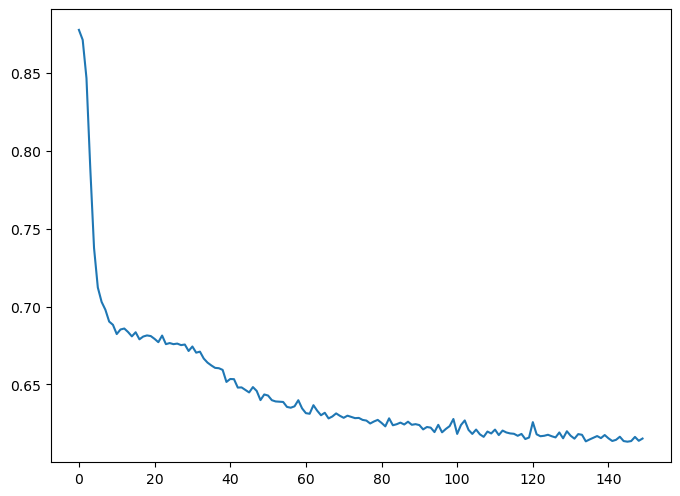

In [472]:
plt.plot(history.history['mean_absolute_error'])

In [473]:
tf.keras.models.save_model(model,'Saved Models/'+setting)

INFO:tensorflow:Assets written to: Saved Models/LSTM_monthly_R3_6/assets


INFO:tensorflow:Assets written to: Saved Models/LSTM_monthly_R3_6/assets


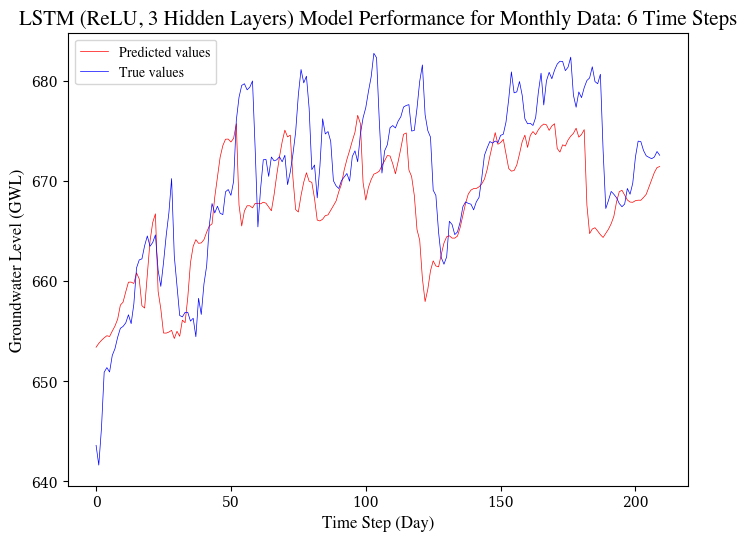

In [474]:
plt.rcParams['font.family'] = 'serif'
f='Times'
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title(title, family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})
plt.savefig('Figures/'+setting+'_serif.png', dpi=300)
plt.show()

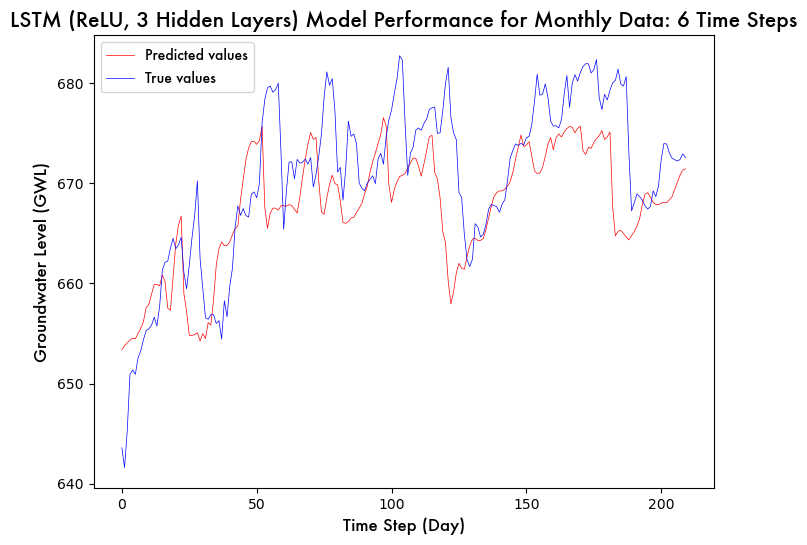

In [475]:
plt.rcParams['font.family'] = 'sans-serif'
f='Futura'
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title(title, family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})
plt.savefig('Figures/'+setting+'_sans-serif.png', dpi=300)
plt.show()

In [476]:
print('R2 = ' + str(r2*100) + "%")
print('MSE = ' + str(mse))
print('MAE = ' + str(mae))

R2 = 51.82666373772118%
MSE = 42.24981604487142
MAE = 4.909485383733633
